In [1]:

import dlib
import cv2 as cv
from mtcnn.mtcnn import MTCNN
import face_recognition as facer

from tqdm import tqdm
from tqdm import tnrange
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plot


/data/soft/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
pNum = "T000001"

proj = "/root/proj/SecurityAI_Round1"
pimg = f"{proj}/Data/images"
pmdl = f"{proj}/Model"
pout = f"{proj}/Out/{pNum}"

In [3]:
# st, ed = 1, 100
st, ed = 1, 712


In [4]:
modelv = "_81"
detector = dlib.get_frontal_face_detector()
%time predictor = dlib.shape_predictor(f"{pmdl}/shape_predictor{modelv}_face_landmarks.dat")


def f_xy(images):
    min_y, max_y, min_x, max_x = 112, 0, 112, 0
    cv_face = detector(cv.cvtColor(images, cv.COLOR_BGR2GRAY), 1)
    if cv_face:
        for face in cv_face:
            shape = predictor(images, face)
            for pt in shape.parts():
                min_y, max_y = min(pt.y, min_y), max(pt.y, max_y)
                min_x, max_x = min(pt.x, min_x), max(pt.x, max_x)
    else:
        min_y, max_y, min_x, max_x = 0, 112, 0, 112
    
    min_y, max_y, min_x, max_x = max(min_y,0), min(max_y,112), max(min_x,0), min(max_x,112)
    return min_y, max_y, min_x, max_x

print(
    f_xy(cv.imread(f"{pimg}/00001.jpg")), 
    f_xy(cv.imread(f"{pimg}/00003.jpg"))
)
%time f_xy(cv.imread(f"{pimg}/00001.jpg"))


CPU times: user 270 ms, sys: 14 ms, total: 284 ms
Wall time: 282 ms
(16, 112, 19, 102) (0, 112, 0, 112)
CPU times: user 11.9 ms, sys: 0 ns, total: 11.9 ms
Wall time: 11.4 ms


(16, 112, 19, 102)

In [5]:
%time dmtcnn = MTCNN()

def f_xy_mtcnn(images):
    rdetector = dmtcnn.detect_faces(images)
    min_y, max_y, min_x, max_x = 112, 0, 112, 0
    if rdetector:
        x, y, w, h = rdetector[0]["box"]
        min_y, max_y, min_x, max_x = y, y+h, x, x+w
    else:
        min_y, max_y, min_x, max_x = 0, 112, 0, 112
        
    min_y, max_y, min_x, max_x = max(min_y,0), min(max_y,112), max(min_x,0), min(max_x,112)
    return min_y, max_y, min_x, max_x

print(
    f_xy_mtcnn(cv.imread(f"{pimg}/00001.jpg")), 
    f_xy_mtcnn(cv.imread(f"{pimg}/00003.jpg")),
    f_xy_mtcnn(cv.imread(f"{pimg}/00489.jpg"))
)
%time f_xy_mtcnn(cv.imread(f"{pimg}/00001.jpg"))


CPU times: user 236 ms, sys: 9.26 ms, total: 245 ms
Wall time: 239 ms
(17, 112, 14, 99) (14, 111, 2, 80) (0, 112, 0, 112)
CPU times: user 24.2 ms, sys: 209 µs, total: 24.4 ms
Wall time: 17.8 ms


(17, 112, 14, 99)

In [6]:

def f_xy_facer(images):
    result = facer.face_landmarks(images)
    min_y, max_y, min_x, max_x = 112, 0, 112, 0
    if result:
        resultl = []
        for ir in result[0].values():
            resultl += ir
        for ir in resultl:
            min_y, max_y = min(ir[1], min_y), max(ir[1], max_y)
            min_x, max_x = min(ir[0], min_x), max(ir[0], max_x)
    else:
        min_y, max_y, min_x, max_x = 0, 112, 0, 112
    
    min_y, max_y, min_x, max_x = max(min_y,0), min(max_y,112), max(min_x,0), min(max_x,112)
    return min_y, max_y, min_x, max_x

print(
    f_xy_facer(cv.imread(f"{pimg}/00001.jpg")), 
    f_xy_facer(cv.imread(f"{pimg}/00003.jpg")),
    f_xy_facer(cv.imread(f"{pimg}/00489.jpg"))
)
%time f_xy_facer(cv.imread(f"{pimg}/00004.jpg"))


(36, 112, 19, 102) (0, 112, 0, 112) (0, 112, 0, 112)
CPU times: user 24.4 ms, sys: 937 µs, total: 25.3 ms
Wall time: 24.8 ms


(38, 112, 0, 86)

In [7]:
def f_lf1(f1, f2):
    return np.sqrt(np.sum(np.square(f1 - f2)))

# from sklearn import metrics
# def f_lf1(f1, f2):
#     return np.mean([metrics.mean_squared_error(if1, if2) for if1, if2 in zip(f1, f2)])

print("SAME:%.6f" % f_lf1(cv.imread(f"{pimg}/00001.jpg"), cv.imread(f"{pimg}/00001.jpg")))
print("DIFF:%.6f" % f_lf1(cv.imread(f"{pimg}/00001.jpg"), cv.imread(f"{pimg}/00002.jpg")))
print("DIFF:%.6f" % f_lf1(cv.imread(f"{pimg}/00001.jpg"), cv.imread(f"{pimg}/00406.jpg")))

%time f_lf1(cv.imread(f"{pimg}/00001.jpg"), cv.imread(f"{pimg}/00002.jpg"))


SAME:0.000000
DIFF:1974.158302
DIFF:1993.636627
CPU times: user 837 µs, sys: 0 ns, total: 837 µs
Wall time: 850 µs


1974.1583016566833

In [8]:
fx1 = lambda x1, x2, x3: max(x1,x2)
fx2 = lambda x1, x2, x3: min(x1,x2)


7968


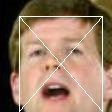

In [9]:
pi = f"{pimg}/"+f"00001.jpg"
op = f"{proj}/Data/Z1.jpg"
img = cv.imread(pi)

min_y, max_y, min_x, max_x = f_xy(img)
print((max_y-min_y)*(max_x-min_x))

cv.line(img, (min_x, min_y), (max_x, max_y), (255, 255, 255))
cv.line(img, (min_x, min_y), (min_x, max_y), (255, 255, 255))
cv.line(img, (min_x, min_y), (max_x, min_y), (255, 255, 255))

cv.line(img, (min_x, max_y), (max_x, max_y), (255, 255, 255))
cv.line(img, (min_x, max_y), (min_x, max_y), (255, 255, 255))
cv.line(img, (min_x, max_y), (max_x, min_y), (255, 255, 255))

cv.line(img, (max_x, min_y), (max_x, max_y), (255, 255, 255))
cv.line(img, (max_x, min_y), (min_x, max_y), (255, 255, 255))
cv.line(img, (max_x, min_y), (max_x, min_y), (255, 255, 255))

cv.line(img, (max_x, max_y), (max_x, max_y), (255, 255, 255))
cv.line(img, (max_x, max_y), (min_x, max_y), (255, 255, 255))
cv.line(img, (max_x, max_y), (max_x, min_y), (255, 255, 255))

cv.imwrite(op, img)
Image(filename=op, width=300, height=300)

8075


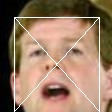

In [10]:
pi = f"{pimg}/"+f"00001.jpg"
op = f"{proj}/Data/Z1.jpg"
img = cv.imread(pi)

min_y, max_y, min_x, max_x = f_xy_mtcnn(img)
print((max_y-min_y)*(max_x-min_x))

cv.line(img, (min_x, min_y), (max_x, max_y), (255, 255, 255))
cv.line(img, (min_x, min_y), (min_x, max_y), (255, 255, 255))
cv.line(img, (min_x, min_y), (max_x, min_y), (255, 255, 255))

cv.line(img, (min_x, max_y), (max_x, max_y), (255, 255, 255))
cv.line(img, (min_x, max_y), (min_x, max_y), (255, 255, 255))
cv.line(img, (min_x, max_y), (max_x, min_y), (255, 255, 255))

cv.line(img, (max_x, min_y), (max_x, max_y), (255, 255, 255))
cv.line(img, (max_x, min_y), (min_x, max_y), (255, 255, 255))
cv.line(img, (max_x, min_y), (max_x, min_y), (255, 255, 255))

cv.line(img, (max_x, max_y), (max_x, max_y), (255, 255, 255))
cv.line(img, (max_x, max_y), (min_x, max_y), (255, 255, 255))
cv.line(img, (max_x, max_y), (max_x, min_y), (255, 255, 255))

cv.imwrite(op, img)
Image(filename=op, width=300, height=300)

6308


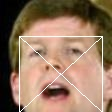

In [11]:
pi = f"{pimg}/"+f"00001.jpg"
op = f"{proj}/Data/Z1.jpg"
img = cv.imread(pi)

min_y, max_y, min_x, max_x = f_xy_facer(img)
print((max_y-min_y)*(max_x-min_x))

cv.line(img, (min_x, min_y), (max_x, max_y), (255, 255, 255))
cv.line(img, (min_x, min_y), (min_x, max_y), (255, 255, 255))
cv.line(img, (min_x, min_y), (max_x, min_y), (255, 255, 255))

cv.line(img, (min_x, max_y), (max_x, max_y), (255, 255, 255))
cv.line(img, (min_x, max_y), (min_x, max_y), (255, 255, 255))
cv.line(img, (min_x, max_y), (max_x, min_y), (255, 255, 255))

cv.line(img, (max_x, min_y), (max_x, max_y), (255, 255, 255))
cv.line(img, (max_x, min_y), (min_x, max_y), (255, 255, 255))
cv.line(img, (max_x, min_y), (max_x, min_y), (255, 255, 255))

cv.line(img, (max_x, max_y), (max_x, max_y), (255, 255, 255))
cv.line(img, (max_x, max_y), (min_x, max_y), (255, 255, 255))
cv.line(img, (max_x, max_y), (max_x, min_y), (255, 255, 255))

cv.imwrite(op, img)
Image(filename=op, width=300, height=300)

7600


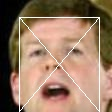

In [12]:
pi = f"{pimg}/"+f"00001.jpg"
op = f"{proj}/Data/Z1.jpg"
img = cv.imread(pi)

min_y1, max_y1, min_x1, max_x1 = f_xy(img)
min_y2, max_y2, min_x2, max_x2 = f_xy_mtcnn(img)
min_y3, max_y3, min_x3, max_x3 = f_xy_facer(img)

min_yl, max_yl = fx1(min_y1,min_y2,min_y3), fx2(max_y1,max_y2,max_y3)
min_xl, max_xl = fx1(min_x1,min_x2,min_x3), fx2(max_x1,max_x2,max_x3)

min_y, max_y, min_x, max_x = min_yl, max_yl, min_xl, max_xl
print((max_y-min_y)*(max_x-min_x))

cv.line(img, (min_x, min_y), (max_x, max_y), (255, 255, 255))
cv.line(img, (min_x, min_y), (min_x, max_y), (255, 255, 255))
cv.line(img, (min_x, min_y), (max_x, min_y), (255, 255, 255))

cv.line(img, (min_x, max_y), (max_x, max_y), (255, 255, 255))
cv.line(img, (min_x, max_y), (min_x, max_y), (255, 255, 255))
cv.line(img, (min_x, max_y), (max_x, min_y), (255, 255, 255))

cv.line(img, (max_x, min_y), (max_x, max_y), (255, 255, 255))
cv.line(img, (max_x, min_y), (min_x, max_y), (255, 255, 255))
cv.line(img, (max_x, min_y), (max_x, min_y), (255, 255, 255))

cv.line(img, (max_x, max_y), (max_x, max_y), (255, 255, 255))
cv.line(img, (max_x, max_y), (min_x, max_y), (255, 255, 255))
cv.line(img, (max_x, max_y), (max_x, min_y), (255, 255, 255))

cv.imwrite(op, img)
Image(filename=op, width=300, height=300)

In [13]:

def min_max_x_y(images):
    min_y1, max_y1, min_x1, max_x1 = f_xy(images)
    min_y2, max_y2, min_x2, max_x2 = f_xy_mtcnn(images)
    min_y3, max_y3, min_x3, max_x3 = f_xy_facer(images)
    
    min_y, max_y = fx1(min_y1,min_y2,min_y3), fx2(max_y1,max_y2,max_y3)
    min_x, max_x = fx1(min_x1,min_x2,min_x3), fx2(max_x1,max_x2,max_x3)
    return min_y, max_y, min_x, max_x


def frun(tpath, time):
    d = 25.5
    
    for i in tnrange(st, ed+1, desc=f"S{time+1}"):
        pi = f"{pimg}/"+f"00000{i}"[-5:]+".jpg"
        op = f"{pout}/images/"+f"00000{i}"[-5:]+".jpg"

        img = cv.imread(pi)
        imgj, min_p012 = 1, 99999.0
                
        min_yl, max_yl, min_xl, max_xl = min_max_x_y(img)
        
        for imgi in tnrange(st, ed+1, 1, desc=f"{i}"):
            imgx = cv.imread(tpath+f"00000{imgi}"[-5:]+".jpg")
            
            if not isinstance(imgx, type(None)):
                p012 = f_lf1(
                    img[min_yl:max_yl, min_xl:max_xl],
                    np.clip(
                        imgx[min_yl:max_yl, min_xl:max_xl], 
                        img[min_yl:max_yl, min_xl:max_xl]-d, 
                        img[min_yl:max_yl, min_xl:max_xl]+d
                    )
                )
                
                if p012 < min_p012 and imgi != i:
                    imgj, min_p012 = imgi, p012

        print(f"{i},{imgj}, Avg:{min_p012:.{6}}", min_yl, max_yl, min_yl, max_yl)
        
        img_o = img.copy()
        img_g = cv.imread(tpath+f"00000{imgj}"[-5:]+".jpg")
    
        img_o[min_yl:max_yl, min_xl:max_xl] = img_g[min_yl:max_yl, min_xl:max_xl]
        img_o = np.clip(img_o, img-d, img+d)        
        cv.imwrite(op, img_o)


frun(tpath=f"{pimg}/", time=0)



1,401, Avg:2899.48 17 112 17 112


2,233, Avg:2998.49 20 112 20 112


3,116, Avg:3165.99 14 111 14 111


4,368, Avg:3014.74 11 112 11 112


5,111, Avg:2787.58 17 109 17 109


6,245, Avg:2742.48 13 112 13 112


7,655, Avg:3294.53 11 111 11 111


8,123, Avg:2708.26 13 109 13 109


9,704, Avg:2685.8 17 112 17 112


10,219, Avg:2350.63 29 109 29 109


11,161, Avg:2779.5 15 111 15 111


12,224, Avg:3222.16 21 112 21 112


13,112, Avg:2681.65 20 112 20 112


14,523, Avg:2665.06 15 112 15 112


15,449, Avg:2803.11 13 112 13 112


16,196, Avg:2709.17 14 112 14 112


17,278, Avg:2671.56 17 112 17 112


18,229, Avg:2810.07 10 111 10 111


19,233, Avg:3053.94 14 112 14 112


20,155, Avg:2849.2 16 112 16 112


21,711, Avg:2671.61 20 112 20 112


22,65, Avg:3019.45 16 109 16 109


23,386, Avg:2634.9 22 111 22 111


24,155, Avg:2702.35 19 112 19 112


25,645, Avg:2748.34 17 110 17 110


26,328, Avg:2871.56 16 109 16 109


27,608, Avg:2671.18 18 112 18 112


28,453, Avg:2945.71 17 112 17 112


29,318, Avg:2954.91 15 112 15 112


30,572, Avg:2779.29 14 112 14 112


31,262, Avg:3089.79 18 110 18 110


32,429, Avg:3008.62 13 112 13 112


33,155, Avg:3042.64 19 112 19 112


34,588, Avg:2645.06 13 111 13 111


35,194, Avg:2939.4 15 112 15 112


36,572, Avg:2357.78 17 112 17 112


37,581, Avg:2802.88 13 111 13 111


38,16, Avg:2936.56 15 112 15 112


39,222, Avg:2463.88 16 112 16 112


40,356, Avg:2762.42 16 112 16 112


41,294, Avg:3010.06 10 111 10 111


42,71, Avg:2662.2 11 109 11 109


43,613, Avg:2759.53 15 110 15 110


44,592, Avg:2876.95 12 112 12 112


45,496, Avg:2674.85 19 112 19 112


46,244, Avg:2878.45 13 112 13 112


47,565, Avg:2864.07 11 112 11 112


48,453, Avg:2681.29 21 112 21 112


49,332, Avg:2680.98 18 112 18 112


50,539, Avg:2605.99 14 111 14 111


51,600, Avg:2741.58 20 111 20 111


52,310, Avg:2910.52 12 112 12 112


53,118, Avg:2655.25 12 109 12 109


54,658, Avg:2879.5 19 112 19 112


55,550, Avg:2920.19 16 109 16 109


56,527, Avg:2916.55 15 111 15 111


57,661, Avg:3069.65 19 112 19 112


58,166, Avg:2675.92 16 112 16 112


59,700, Avg:2853.54 13 112 13 112


60,644, Avg:2901.16 18 112 18 112


61,711, Avg:2826.35 11 112 11 112


62,408, Avg:2608.91 17 112 17 112


63,401, Avg:2928.41 13 111 13 111


64,15, Avg:2999.11 12 112 12 112


65,22, Avg:3027.59 21 112 21 112


66,163, Avg:2614.15 16 111 16 111


67,531, Avg:2838.55 12 112 12 112


68,493, Avg:3396.13 1 112 1 112


69,218, Avg:2627.98 18 112 18 112


70,101, Avg:2805.42 12 110 12 110


71,42, Avg:2702.24 11 111 11 111


72,261, Avg:2755.45 10 112 10 112


73,136, Avg:3010.56 17 111 17 111


74,318, Avg:2677.47 17 112 17 112


75,369, Avg:3333.3 6 112 6 112


76,114, Avg:2878.77 18 111 18 111


77,408, Avg:2762.39 13 112 13 112


78,362, Avg:3132.13 19 112 19 112


79,441, Avg:2875.73 21 112 21 112


80,510, Avg:2831.6 20 112 20 112


81,331, Avg:3175.89 14 111 14 111


82,336, Avg:3041.64 12 112 12 112


83,381, Avg:2659.34 17 112 17 112


84,618, Avg:3051.87 13 110 13 110


85,497, Avg:2947.51 12 112 12 112


86,138, Avg:2637.81 14 112 14 112


87,598, Avg:3107.13 17 112 17 112


88,633, Avg:2832.19 14 112 14 112


89,513, Avg:2898.18 19 112 19 112


90,229, Avg:2514.08 13 112 13 112


91,515, Avg:2758.91 19 109 19 109


92,35, Avg:2928.13 15 112 15 112


93,185, Avg:2590.11 14 112 14 112


94,590, Avg:2743.55 14 110 14 110


95,222, Avg:2815.18 13 110 13 110


96,94, Avg:2986.42 13 112 13 112


97,402, Avg:2911.75 13 112 13 112


98,163, Avg:2695.55 14 112 14 112


99,93, Avg:2780.64 14 112 14 112


100,579, Avg:2693.43 20 112 20 112


101,235, Avg:2433.51 19 112 19 112


102,244, Avg:2688.35 14 112 14 112


103,585, Avg:2987.34 10 110 10 110


104,704, Avg:2495.64 13 107 13 107


105,653, Avg:2905.87 16 112 16 112


106,356, Avg:3060.88 15 112 15 112


107,426, Avg:3033.26 13 112 13 112


108,615, Avg:2565.35 22 112 22 112


109,496, Avg:2382.51 18 111 18 111


110,683, Avg:2829.87 16 111 16 111


111,623, Avg:2421.7 18 109 18 109


112,381, Avg:2676.12 14 112 14 112


113,261, Avg:2768.54 15 112 15 112


114,670, Avg:2783.72 19 111 19 111


115,613, Avg:2648.84 23 107 23 107


116,491, Avg:2847.37 19 112 19 112


117,179, Avg:2586.7 18 109 18 109


118,161, Avg:2551.19 12 110 12 110


119,278, Avg:2943.49 11 112 11 112


120,565, Avg:2622.33 16 110 16 110


121,679, Avg:2635.27 12 108 12 108


122,94, Avg:2683.3 16 110 16 110


123,623, Avg:2473.57 15 111 15 111


124,88, Avg:2985.57 13 111 13 111


125,649, Avg:2943.04 22 112 22 112


126,429, Avg:2780.14 13 112 13 112


127,209, Avg:2440.46 17 109 17 109


128,45, Avg:2669.15 19 112 19 112


129,424, Avg:2886.5 15 112 15 112


130,682, Avg:3120.27 19 112 19 112


131,426, Avg:2891.4 16 112 16 112


132,157, Avg:2938.99 14 112 14 112


133,653, Avg:2646.68 16 112 16 112


134,88, Avg:2723.36 19 112 19 112


135,311, Avg:3016.71 15 112 15 112


136,73, Avg:2954.54 24 112 24 112


137,644, Avg:2960.08 14 112 14 112


138,86, Avg:2496.22 16 112 16 112


139,485, Avg:2982.89 19 109 19 109


140,638, Avg:2845.8 17 112 17 112


141,381, Avg:2532.7 16 110 16 110


142,194, Avg:2995.86 14 112 14 112


143,350, Avg:2921.08 16 112 16 112


144,600, Avg:2537.28 14 108 14 108


145,161, Avg:2727.02 17 112 17 112


146,627, Avg:2811.45 14 112 14 112


147,396, Avg:2773.28 18 112 18 112


148,653, Avg:2895.52 13 111 13 111


149,127, Avg:2474.62 17 110 17 110


150,549, Avg:2919.61 20 112 20 112


151,597, Avg:2792.49 15 112 15 112


152,229, Avg:2508.86 18 112 18 112


153,118, Avg:2846.39 14 112 14 112


154,399, Avg:2929.83 23 112 23 112


155,286, Avg:2844.59 14 112 14 112


156,232, Avg:2965.56 14 112 14 112


157,132, Avg:2679.47 20 112 20 112


158,340, Avg:3231.81 20 112 20 112


159,74, Avg:2852.05 19 112 19 112


160,197, Avg:2785.53 13 112 13 112


161,600, Avg:2494.06 14 110 14 110


162,144, Avg:2765.66 15 112 15 112


163,66, Avg:2570.62 14 112 14 112


164,235, Avg:2783.29 13 112 13 112


165,418, Avg:2811.0 15 112 15 112


166,349, Avg:2703.16 15 107 15 107


167,487, Avg:2566.52 13 112 13 112


168,453, Avg:2686.68 11 112 11 112


169,447, Avg:2835.76 17 109 17 109


170,705, Avg:2993.65 19 112 19 112


171,187, Avg:2627.86 12 112 12 112


172,27, Avg:2871.35 18 112 18 112


173,613, Avg:2675.66 13 110 13 110


174,661, Avg:3293.22 19 112 19 112


175,428, Avg:3087.75 11 111 11 111


176,613, Avg:2771.56 17 112 17 112


177,61, Avg:2614.52 15 112 15 112


178,222, Avg:2558.74 18 108 18 108


179,417, Avg:2926.02 9 112 9 112


180,459, Avg:2971.58 12 107 12 107


181,496, Avg:2622.11 15 108 15 108


182,623, Avg:2357.49 15 110 15 110


183,368, Avg:2822.09 12 112 12 112


184,672, Avg:2696.19 16 112 16 112


185,313, Avg:2617.37 15 112 15 112


186,19, Avg:3285.18 15 112 15 112


187,564, Avg:2809.33 15 112 15 112


188,326, Avg:3373.02 8 112 8 112


189,528, Avg:3167.02 14 112 14 112


190,183, Avg:2987.87 14 111 14 111


191,380, Avg:2738.98 13 112 13 112


192,76, Avg:2778.07 21 110 21 110


193,205, Avg:2971.79 19 112 19 112


194,696, Avg:2961.61 11 112 11 112


195,39, Avg:2463.13 20 112 20 112


196,282, Avg:2633.78 13 108 13 108


197,160, Avg:2593.53 21 112 21 112


198,599, Avg:2954.01 14 112 14 112


199,711, Avg:2780.48 12 110 12 110


200,442, Avg:2562.45 16 109 16 109


201,39, Avg:2747.0 20 112 20 112


202,333, Avg:2941.71 21 112 21 112


203,304, Avg:3079.44 16 110 16 110


204,340, Avg:2880.37 12 110 12 110


205,352, Avg:2674.76 21 112 21 112


206,46, Avg:2849.64 13 112 13 112


207,467, Avg:2580.86 16 112 16 112


208,278, Avg:2823.09 12 110 12 110


209,127, Avg:2486.96 15 112 15 112


210,22, Avg:2920.55 24 111 24 111


211,606, Avg:2646.7 14 112 14 112


212,99, Avg:3009.59 10 112 10 112


213,686, Avg:2976.78 18 112 18 112


214,332, Avg:2410.94 21 110 21 110


215,67, Avg:2800.4 13 112 13 112


216,208, Avg:2951.72 16 112 16 112


217,352, Avg:3036.65 20 112 20 112


218,347, Avg:2676.82 12 112 12 112


219,600, Avg:2372.98 20 107 20 107


220,162, Avg:2769.04 21 112 21 112


221,463, Avg:2625.72 15 112 15 112


222,39, Avg:2407.65 16 110 16 110


223,345, Avg:3055.79 20 112 20 112


224,573, Avg:2681.46 17 108 17 108


225,615, Avg:3022.73 11 112 11 112


226,311, Avg:2889.68 18 112 18 112


227,668, Avg:3057.04 17 112 17 112


228,74, Avg:2978.22 12 111 12 111


229,301, Avg:2354.13 17 110 17 110


230,313, Avg:2980.25 24 112 24 112


231,453, Avg:2289.11 15 110 15 110


232,653, Avg:2764.13 15 111 15 111


233,264, Avg:2725.89 15 112 15 112


234,446, Avg:2787.14 11 108 11 108


235,101, Avg:2551.47 17 112 17 112


236,433, Avg:2769.58 17 112 17 112


237,219, Avg:2832.33 18 112 18 112


238,144, Avg:2832.89 14 112 14 112


239,599, Avg:2503.21 20 107 20 107


240,112, Avg:2866.74 18 112 18 112


241,104, Avg:2538.86 15 112 15 112


242,182, Avg:2692.25 17 112 17 112


243,253, Avg:2749.32 16 108 16 108


244,278, Avg:2587.5 16 112 16 112


245,6, Avg:2600.98 14 112 14 112


246,632, Avg:3113.38 18 112 18 112


247,280, Avg:3117.88 10 112 10 112


248,222, Avg:2755.85 17 109 17 109


249,571, Avg:2632.88 12 112 12 112


250,712, Avg:2864.53 11 112 11 112


251,39, Avg:2713.99 17 112 17 112


252,289, Avg:2710.31 19 112 19 112


253,332, Avg:2489.73 17 111 17 111


254,653, Avg:2722.35 16 110 16 110


255,93, Avg:2593.91 17 112 17 112


256,237, Avg:2948.31 16 112 16 112


257,155, Avg:3000.19 24 112 24 112


258,613, Avg:2847.34 17 103 17 103


259,625, Avg:2869.98 19 112 19 112


260,93, Avg:2693.99 14 112 14 112


261,72, Avg:2662.58 10 109 10 109


262,21, Avg:2736.25 16 112 16 112


263,278, Avg:2844.97 15 111 15 111


264,704, Avg:2518.55 16 111 16 111


265,624, Avg:2859.67 21 112 21 112


266,685, Avg:2919.95 17 111 17 111


267,25, Avg:2999.9 17 112 17 112


268,613, Avg:2855.43 17 110 17 110


269,428, Avg:3034.32 13 112 13 112


270,133, Avg:2709.11 14 108 14 108


271,261, Avg:2900.3 12 112 12 112


272,478, Avg:2783.97 13 109 13 109


273,375, Avg:2628.96 17 112 17 112


274,336, Avg:2684.46 15 112 15 112


275,374, Avg:2875.34 24 112 24 112


276,453, Avg:2797.62 15 110 15 110


277,573, Avg:2844.17 13 110 13 110


278,417, Avg:2786.44 14 112 14 112


279,135, Avg:3135.86 14 112 14 112


280,247, Avg:3211.67 10 112 10 112


281,434, Avg:2725.78 15 112 15 112


282,196, Avg:2660.4 11 110 11 110


283,596, Avg:2675.4 19 110 19 110


284,340, Avg:2595.69 16 112 16 112


285,326, Avg:2882.06 15 111 15 111


286,608, Avg:2603.72 11 112 11 112


287,555, Avg:3012.23 12 112 12 112


288,690, Avg:2515.03 16 109 16 109


289,297, Avg:2651.59 18 112 18 112


290,486, Avg:2829.02 17 112 17 112


291,326, Avg:2910.47 15 112 15 112


292,629, Avg:3023.96 18 112 18 112


293,335, Avg:2638.8 18 112 18 112


294,457, Avg:2855.54 14 112 14 112


295,381, Avg:2795.2 14 112 14 112


296,554, Avg:2467.96 21 110 21 110


297,289, Avg:2550.94 15 107 15 107


298,221, Avg:2592.41 18 109 18 109


299,386, Avg:2530.16 25 112 25 112


300,229, Avg:3049.46 12 112 12 112


301,370, Avg:2468.65 15 110 15 110


302,340, Avg:2671.89 17 112 17 112


303,615, Avg:2622.49 13 112 13 112


304,379, Avg:2990.1 17 112 17 112


305,495, Avg:2673.96 19 112 19 112


306,683, Avg:2703.84 15 112 15 112


307,596, Avg:2772.19 15 110 15 110


308,127, Avg:2643.15 19 112 19 112


309,175, Avg:3050.04 15 112 15 112


310,418, Avg:2796.21 16 112 16 112


311,118, Avg:2712.25 13 112 13 112


312,401, Avg:2933.88 9 112 9 112


313,418, Avg:2485.1 17 112 17 112


314,463, Avg:3060.17 13 112 13 112


315,262, Avg:2750.83 15 112 15 112


316,311, Avg:2729.63 15 112 15 112


317,163, Avg:2956.85 15 112 15 112


318,74, Avg:2673.95 17 112 17 112


319,585, Avg:2717.01 15 109 15 109


320,548, Avg:2995.41 12 112 12 112


321,444, Avg:2933.35 13 111 13 111


322,453, Avg:2925.42 9 112 9 112


323,614, Avg:2795.22 19 112 19 112


324,312, Avg:3006.61 17 112 17 112


325,363, Avg:3024.15 14 112 14 112


326,113, Avg:2757.58 17 110 17 110


327,155, Avg:2694.32 19 112 19 112


328,26, Avg:2998.76 17 112 17 112


329,599, Avg:2843.18 8 112 8 112


330,250, Avg:2986.24 12 112 12 112


331,498, Avg:2935.72 16 108 16 108


332,109, Avg:2487.39 19 112 19 112


333,370, Avg:3124.89 12 112 12 112


334,50, Avg:2945.85 16 112 16 112


335,590, Avg:2711.94 15 112 15 112


336,274, Avg:2799.59 17 111 17 111


337,218, Avg:3196.34 12 112 12 112


338,530, Avg:2826.66 12 110 12 110


339,529, Avg:3026.17 18 112 18 112


340,71, Avg:2792.99 12 112 12 112


341,513, Avg:2726.02 19 112 19 112


342,416, Avg:2636.25 18 110 18 110


343,344, Avg:2827.06 17 110 17 110


344,596, Avg:2839.28 16 112 16 112


345,93, Avg:2628.18 15 110 15 110


346,708, Avg:2976.51 16 110 16 110


347,218, Avg:2662.15 15 112 15 112


348,539, Avg:2600.41 17 111 17 111


349,166, Avg:2579.83 20 112 20 112


350,143, Avg:2774.87 17 107 17 107


351,711, Avg:2731.93 17 112 17 112


352,6, Avg:2761.25 15 112 15 112


353,280, Avg:2871.28 17 112 17 112


354,679, Avg:2854.99 16 112 16 112


355,236, Avg:2928.53 14 112 14 112


356,39, Avg:2761.84 14 112 14 112


357,512, Avg:2789.08 19 112 19 112


358,418, Avg:2557.39 13 112 13 112


359,355, Avg:2921.82 15 111 15 111


360,440, Avg:2483.76 19 112 19 112


361,14, Avg:2675.12 19 112 19 112


362,326, Avg:3047.48 13 110 13 110


363,426, Avg:2762.65 18 112 18 112


364,112, Avg:2715.68 15 112 15 112


365,222, Avg:2779.21 16 110 16 110


366,697, Avg:3287.13 16 112 16 112


367,149, Avg:2883.47 14 112 14 112


368,183, Avg:2801.65 11 112 11 112


369,351, Avg:2817.77 12 109 12 109


370,301, Avg:2357.89 20 112 20 112


371,335, Avg:2934.84 12 112 12 112


372,329, Avg:2895.67 17 112 17 112


373,191, Avg:3008.18 12 112 12 112


374,407, Avg:2855.87 22 111 22 111


375,496, Avg:2502.14 18 112 18 112


376,405, Avg:3207.07 7 112 7 112


377,311, Avg:2867.35 18 112 18 112


378,605, Avg:2888.43 19 109 19 109


379,478, Avg:2857.38 17 112 17 112


380,191, Avg:2681.73 17 112 17 112


381,672, Avg:2676.47 13 112 13 112


382,181, Avg:2644.04 18 108 18 108


383,429, Avg:3019.4 13 112 13 112


384,244, Avg:2657.08 11 112 11 112


385,514, Avg:2875.52 12 112 12 112


386,539, Avg:2770.15 16 112 16 112


387,386, Avg:2830.35 18 112 18 112


388,126, Avg:3011.91 11 112 11 112


389,137, Avg:3175.78 12 112 12 112


390,149, Avg:2600.12 19 110 19 110


391,505, Avg:2843.71 19 112 19 112


392,367, Avg:2954.96 14 112 14 112


393,116, Avg:2174.71 28 105 28 105


394,491, Avg:2967.97 14 112 14 112


395,241, Avg:2768.59 12 109 12 109


396,147, Avg:2673.47 19 112 19 112


397,50, Avg:3081.34 16 112 16 112


398,711, Avg:2850.08 21 112 21 112


399,453, Avg:2410.12 19 112 19 112


400,442, Avg:2735.8 12 112 12 112


401,426, Avg:2581.19 15 112 15 112


402,284, Avg:2913.99 14 112 14 112


403,596, Avg:2930.32 21 112 21 112


404,194, Avg:2962.8 12 112 12 112


405,376, Avg:2942.64 13 112 13 112


406,342, Avg:3157.53 15 112 15 112


407,6, Avg:2769.03 16 112 16 112


408,77, Avg:2817.61 13 112 13 112


409,432, Avg:3007.09 9 111 9 111


410,625, Avg:2262.53 15 112 15 112


411,638, Avg:2793.03 15 112 15 112


412,401, Avg:2950.86 15 112 15 112


413,513, Avg:2908.35 17 112 17 112


414,177, Avg:3035.09 13 112 13 112


415,417, Avg:2773.68 21 112 21 112


416,342, Avg:2764.23 17 112 17 112


417,278, Avg:2635.01 17 112 17 112


418,358, Avg:2571.65 15 112 15 112


419,379, Avg:2745.54 21 111 21 111


420,549, Avg:3144.3 16 112 16 112


421,478, Avg:2831.79 14 112 14 112


422,368, Avg:2794.52 18 112 18 112


423,198, Avg:3080.46 9 112 9 112


424,565, Avg:2838.7 14 111 14 111


425,207, Avg:2848.61 16 112 16 112


426,613, Avg:2473.07 17 109 17 109


427,463, Avg:2736.37 17 111 17 111


428,212, Avg:3041.84 15 112 15 112


429,484, Avg:2672.13 17 112 17 112


430,453, Avg:2438.65 18 112 18 112


431,573, Avg:2700.88 18 112 18 112


432,559, Avg:2982.93 13 111 13 111


433,144, Avg:2766.77 16 112 16 112


434,512, Avg:2589.36 16 110 16 110


435,358, Avg:2780.62 12 112 12 112


436,615, Avg:2387.37 18 109 18 109


437,686, Avg:2718.28 17 112 17 112


438,478, Avg:2747.18 21 112 21 112


439,332, Avg:2721.83 14 112 14 112


440,505, Avg:2530.52 16 112 16 112


441,682, Avg:2830.04 14 111 14 111


442,400, Avg:2590.23 16 112 16 112


443,486, Avg:2851.47 10 110 10 110


444,625, Avg:2781.12 16 109 16 109


445,269, Avg:2891.85 16 112 16 112


446,234, Avg:2776.7 12 112 12 112


447,658, Avg:2536.94 15 108 15 108


448,402, Avg:2768.18 14 110 14 110


449,15, Avg:2772.18 18 112 18 112


450,298, Avg:2802.7 18 112 18 112


451,608, Avg:2781.94 11 112 11 112


452,157, Avg:2967.77 18 112 18 112


453,231, Avg:2335.74 12 112 12 112


454,523, Avg:2788.88 17 112 17 112


455,146, Avg:2838.43 17 112 17 112


456,19, Avg:2857.22 19 112 19 112


457,572, Avg:2701.65 14 111 14 111


458,439, Avg:2911.07 20 110 20 110


459,258, Avg:3031.75 16 112 16 112


460,150, Avg:3075.07 17 112 17 112


461,625, Avg:2670.63 15 112 15 112


462,402, Avg:2870.03 18 112 18 112


463,149, Avg:2579.69 16 111 16 111


464,280, Avg:2861.15 22 112 22 112


465,424, Avg:3050.03 10 112 10 112


466,204, Avg:3184.56 14 110 14 110


467,207, Avg:2396.26 15 105 15 105


468,711, Avg:2425.09 20 111 20 111


469,282, Avg:2798.92 12 107 12 107


470,15, Avg:3113.8 15 112 15 112


471,599, Avg:3538.42 9 112 9 112


472,619, Avg:2592.75 12 110 12 110


473,581, Avg:2677.67 18 112 18 112


474,242, Avg:2859.89 15 112 15 112


475,374, Avg:3035.41 13 112 13 112


476,205, Avg:2947.76 18 112 18 112


477,229, Avg:2642.21 18 112 18 112


478,168, Avg:2529.06 15 112 15 112


479,608, Avg:2949.63 12 111 12 111


480,613, Avg:2759.07 14 112 14 112


481,222, Avg:2530.3 11 110 11 110


482,149, Avg:2394.13 20 108 20 108


483,282, Avg:2649.37 13 112 13 112


484,429, Avg:2584.32 14 112 14 112


485,518, Avg:2983.53 19 112 19 112


486,443, Avg:2631.18 16 112 16 112


487,167, Avg:2648.97 16 112 16 112


488,358, Avg:2649.76 16 112 16 112


489,244, Avg:4151.33 0 112 0 112


490,307, Avg:2600.52 15 111 15 111


491,116, Avg:2999.99 15 112 15 112


492,647, Avg:2813.41 21 112 21 112


493,43, Avg:3042.08 14 112 14 112


494,229, Avg:2502.91 17 112 17 112


495,305, Avg:2610.45 18 112 18 112


496,109, Avg:2573.31 17 112 17 112


497,109, Avg:2459.1 17 112 17 112


498,331, Avg:3127.97 20 112 20 112


499,521, Avg:3016.36 13 112 13 112


500,434, Avg:2835.04 15 112 15 112


501,512, Avg:2735.63 20 112 20 112


502,596, Avg:2790.23 14 110 14 110


503,345, Avg:2975.08 13 112 13 112


504,168, Avg:2608.03 16 110 16 110


505,440, Avg:2422.83 15 112 15 112


506,66, Avg:2643.15 16 110 16 110


507,80, Avg:2866.68 20 112 20 112


508,344, Avg:2793.52 10 110 10 110


509,298, Avg:2799.41 16 112 16 112


510,80, Avg:2898.18 16 112 16 112


511,428, Avg:3396.52 13 112 13 112


512,434, Avg:2694.18 12 110 12 110


513,625, Avg:2683.55 14 111 14 111


514,681, Avg:2880.06 17 112 17 112


515,681, Avg:2690.2 18 112 18 112


516,697, Avg:4112.17 0 112 0 112


517,301, Avg:2537.95 19 109 19 109


518,162, Avg:2912.96 13 111 13 111


519,313, Avg:2912.9 21 110 21 110


520,183, Avg:2870.92 15 112 15 112


521,499, Avg:2971.8 16 110 16 110


522,386, Avg:2562.39 27 112 27 112


523,623, Avg:2683.24 17 112 17 112


524,679, Avg:2766.47 10 112 10 112


525,596, Avg:2556.56 22 109 22 109


526,138, Avg:2595.79 19 112 19 112


527,56, Avg:2935.88 15 112 15 112


528,97, Avg:3244.23 12 112 12 112


529,530, Avg:2917.96 14 111 14 111


530,565, Avg:2594.35 15 112 15 112


531,67, Avg:2545.41 16 112 16 112


532,225, Avg:2897.12 15 112 15 112


533,166, Avg:2854.97 19 111 19 111


534,251, Avg:2840.02 18 109 18 109


535,700, Avg:2930.09 12 111 12 111


536,531, Avg:2711.09 19 112 19 112


537,563, Avg:2920.07 13 112 13 112


538,313, Avg:2759.62 17 112 17 112


539,50, Avg:2640.61 12 112 12 112


540,630, Avg:2944.66 15 110 15 110


541,624, Avg:2759.0 20 112 20 112


542,621, Avg:2426.48 15 111 15 111


543,448, Avg:3144.99 16 112 16 112


544,711, Avg:2740.59 17 112 17 112


545,229, Avg:2646.76 15 109 15 109


546,340, Avg:2842.72 11 111 11 111


547,478, Avg:3847.31 0 112 0 112


548,163, Avg:2722.07 15 112 15 112


549,150, Avg:2748.07 18 109 18 109


550,222, Avg:2210.08 17 110 17 110


551,439, Avg:2970.51 17 112 17 112


552,288, Avg:2608.56 18 112 18 112


553,707, Avg:3144.13 20 110 20 110


554,296, Avg:2763.84 17 110 17 110


555,436, Avg:2832.99 13 112 13 112


556,21, Avg:2392.89 24 109 24 109


557,530, Avg:3067.44 20 112 20 112


558,461, Avg:2909.2 16 112 16 112


559,185, Avg:2931.72 11 112 11 112


560,605, Avg:2872.08 13 111 13 111


561,573, Avg:2775.03 18 112 18 112


562,116, Avg:3026.56 18 112 18 112


563,537, Avg:2886.0 15 112 15 112


564,161, Avg:2684.18 16 112 16 112


565,347, Avg:2615.06 14 112 14 112


566,420, Avg:2832.1 20 112 20 112


567,440, Avg:2821.48 16 112 16 112


568,99, Avg:2968.4 16 112 16 112


569,618, Avg:2935.27 14 112 14 112


570,418, Avg:2538.8 19 108 19 108


571,496, Avg:2582.05 16 112 16 112


572,36, Avg:2313.14 18 112 18 112


573,649, Avg:2460.74 19 111 19 111


574,658, Avg:2823.05 19 112 19 112


575,141, Avg:2760.76 12 109 12 109


576,109, Avg:2521.54 18 106 18 106


577,611, Avg:2723.54 21 112 21 112


578,134, Avg:2683.23 18 112 18 112


579,439, Avg:2841.48 19 112 19 112


580,229, Avg:2702.09 16 112 16 112


581,531, Avg:2829.52 13 111 13 111


582,651, Avg:3060.22 11 112 11 112


583,146, Avg:2922.1 14 112 14 112


584,441, Avg:2995.27 16 112 16 112


585,319, Avg:2740.01 20 112 20 112


586,239, Avg:2965.17 15 111 15 111


587,573, Avg:2713.67 25 112 25 112


588,34, Avg:2750.46 14 112 14 112


589,335, Avg:2991.93 18 112 18 112


590,335, Avg:2712.84 15 111 15 111


591,429, Avg:2589.47 18 112 18 112


592,310, Avg:2585.28 17 111 17 111


593,332, Avg:2797.29 15 112 15 112


594,608, Avg:2793.76 14 112 14 112


595,410, Avg:2829.93 18 112 18 112


596,658, Avg:2596.3 17 111 17 111


597,45, Avg:2655.01 15 112 15 112


598,265, Avg:3060.28 16 112 16 112


599,441, Avg:2731.01 16 112 16 112


600,161, Avg:2554.91 16 112 16 112


601,163, Avg:2705.26 16 111 16 111


602,539, Avg:2628.73 16 112 16 112


603,72, Avg:2772.51 9 112 9 112


604,99, Avg:2789.49 15 110 15 110


605,482, Avg:2712.57 17 112 17 112


606,211, Avg:2710.53 16 112 16 112


607,505, Avg:2622.01 14 112 14 112


608,71, Avg:2756.6 19 112 19 112


609,666, Avg:2662.58 19 111 19 111


610,40, Avg:2671.74 17 112 17 112


611,625, Avg:2692.91 15 111 15 111


612,609, Avg:2951.59 16 112 16 112


613,426, Avg:2496.21 16 108 16 108


614,45, Avg:2989.39 15 112 15 112


615,436, Avg:2546.74 16 111 16 111


616,655, Avg:3300.47 16 112 16 112


617,311, Avg:3084.76 15 112 15 112


618,162, Avg:2833.78 16 112 16 112


619,472, Avg:2702.92 11 112 11 112


620,150, Avg:2940.66 21 112 21 112


621,381, Avg:2558.86 12 109 12 109


622,37, Avg:2963.53 11 112 11 112


623,182, Avg:2451.71 16 109 16 109


624,90, Avg:2590.87 19 112 19 112


625,410, Avg:2300.38 16 112 16 112


626,608, Avg:2753.2 15 112 15 112


627,277, Avg:2878.05 14 112 14 112


628,596, Avg:2786.21 19 112 19 112


629,292, Avg:2767.96 15 112 15 112


630,708, Avg:2750.07 18 112 18 112


631,262, Avg:2820.03 15 112 15 112


632,119, Avg:3014.98 11 112 11 112


633,88, Avg:2532.6 23 112 23 112


634,639, Avg:3916.41 0 112 0 112


635,402, Avg:2917.17 12 112 12 112


636,649, Avg:2937.82 17 112 17 112


637,332, Avg:2611.63 13 111 13 111


638,411, Avg:2838.17 12 112 12 112


639,101, Avg:2671.47 15 112 15 112


640,161, Avg:2875.31 17 112 17 112


641,411, Avg:2848.72 21 112 21 112


642,572, Avg:2393.61 18 108 18 108


643,281, Avg:3012.62 16 111 16 111


644,363, Avg:3035.87 11 112 11 112


645,25, Avg:2872.27 17 112 17 112


646,281, Avg:2597.42 21 112 21 112


647,235, Avg:2641.32 16 111 16 111


648,461, Avg:2731.93 15 112 15 112


649,573, Avg:2527.52 17 112 17 112


650,561, Avg:2600.7 17 108 17 108


651,582, Avg:3185.96 18 112 18 112


652,654, Avg:2613.02 19 110 19 110


653,127, Avg:2570.23 15 108 15 108


654,253, Avg:2603.32 13 110 13 110


655,199, Avg:3324.32 6 112 6 112


656,448, Avg:3185.69 16 112 16 112


657,86, Avg:2958.23 14 112 14 112


658,596, Avg:2656.06 14 112 14 112


659,187, Avg:2685.71 18 112 18 112


660,670, Avg:3214.66 11 112 11 112


661,401, Avg:2699.42 21 112 21 112


662,617, Avg:3049.94 17 112 17 112


663,229, Avg:3230.03 18 112 18 112


664,311, Avg:2976.06 15 112 15 112


665,643, Avg:2975.03 16 110 16 110


666,167, Avg:2607.09 24 112 24 112


667,132, Avg:2816.18 14 109 14 109


668,39, Avg:2745.76 15 111 15 111


669,235, Avg:2568.46 15 109 15 109


670,185, Avg:2483.4 20 112 20 112


671,379, Avg:2817.84 17 112 17 112


672,690, Avg:2435.87 15 112 15 112


673,199, Avg:3031.49 19 112 19 112


674,698, Avg:3130.84 14 112 14 112


675,523, Avg:2546.85 18 112 18 112


676,307, Avg:3029.87 11 112 11 112


677,461, Avg:2776.99 26 112 26 112


678,310, Avg:2973.86 16 112 16 112


679,264, Avg:2609.42 14 112 14 112


680,690, Avg:2599.25 14 112 14 112


681,515, Avg:2605.23 16 112 16 112


682,441, Avg:2698.88 21 112 21 112


683,686, Avg:2885.63 15 112 15 112


684,187, Avg:2868.46 14 110 14 110


685,443, Avg:2879.09 15 112 15 112


686,161, Avg:2569.73 18 110 18 110


687,437, Avg:2725.13 15 112 15 112


688,301, Avg:2589.45 14 112 14 112


689,112, Avg:2828.49 10 110 10 110


690,672, Avg:2566.62 15 112 15 112


691,138, Avg:2808.13 21 112 21 112


692,378, Avg:3250.34 12 112 12 112


693,15, Avg:2732.6 15 112 15 112


694,324, Avg:2959.06 17 111 17 111


695,384, Avg:2870.89 14 112 14 112


696,194, Avg:2847.94 7 108 7 108


697,672, Avg:2768.81 18 110 18 110


698,133, Avg:2911.73 14 112 14 112


699,685, Avg:2983.56 16 112 16 112


700,648, Avg:3020.9 14 112 14 112


701,426, Avg:2995.96 21 112 21 112


702,347, Avg:2788.14 14 112 14 112


703,148, Avg:3020.49 16 112 16 112


704,104, Avg:2656.56 13 112 13 112


705,635, Avg:3047.24 15 112 15 112


706,666, Avg:3060.16 11 112 11 112


707,229, Avg:2893.26 18 110 18 110


708,207, Avg:3021.64 14 112 14 112


709,116, Avg:3052.17 17 112 17 112


710,394, Avg:2976.19 16 112 16 112


711,61, Avg:2546.4 20 112 20 112


712,141, Avg:2611.31 16 111 16 111



In [14]:
! sh run.sh

.....
  adding: images/ (stored 0%)
  adding: images/00383.jpg (deflated 4%)
  adding: images/00037.jpg (deflated 4%)
  adding: images/00639.jpg (deflated 4%)
  adding: images/00362.jpg (deflated 4%)
  adding: images/00650.jpg (deflated 4%)
  adding: images/00235.jpg (deflated 4%)
  adding: images/00625.jpg (deflated 5%)
  adding: images/00670.jpg (deflated 4%)
  adding: images/00344.jpg (deflated 4%)
  adding: images/00301.jpg (deflated 4%)
  adding: images/00584.jpg (deflated 4%)
  adding: images/00378.jpg (deflated 3%)
  adding: images/00496.jpg (deflated 4%)
  adding: images/00138.jpg (deflated 4%)
  adding: images/00232.jpg (deflated 4%)
  adding: images/00236.jpg (deflated 4%)
  adding: images/00679.jpg (deflated 4%)
  adding: images/00260.jpg (deflated 4%)
  adding: images/00687.jpg (deflated 4%)
  adding: images/00456.jpg (deflated 4%)
  adding: images/00619.jpg (deflated 4%)
  adding: images/00382.jpg (deflated 4%)
  adding: images/00095.jpg (deflated 4%)
  adding: images/0035

  adding: images/00318.jpg (deflated 4%)
  adding: images/00471.jpg (deflated 3%)
  adding: images/00480.jpg (deflated 4%)
  adding: images/00040.jpg (deflated 4%)
  adding: images/00023.jpg (deflated 4%)
  adding: images/00214.jpg (deflated 4%)
  adding: images/00505.jpg (deflated 4%)
  adding: images/00393.jpg (deflated 4%)
  adding: images/00191.jpg (deflated 4%)
  adding: images/00248.jpg (deflated 4%)
  adding: images/00269.jpg (deflated 4%)
  adding: images/00250.jpg (deflated 4%)
  adding: images/00223.jpg (deflated 4%)
  adding: images/00225.jpg (deflated 4%)
  adding: images/00605.jpg (deflated 4%)
  adding: images/00536.jpg (deflated 4%)
  adding: images/00489.jpg (deflated 3%)
  adding: images/00522.jpg (deflated 4%)
  adding: images/00425.jpg (deflated 4%)
  adding: images/00009.jpg (deflated 4%)
  adding: images/00247.jpg (deflated 3%)
  adding: images/00351.jpg (deflated 4%)
  adding: images/00316.jpg (deflated 4%)
  adding: images/00455.jpg (deflated 4%)
  adding: images

  adding: images/00168.jpg (deflated 4%)
  adding: images/00700.jpg (deflated 4%)
  adding: images/00476.jpg (deflated 4%)
  adding: images/00602.jpg (deflated 4%)
.....


In [15]:
#         img_o[min_yl:max_yl, min_xl:max_xl] = cv.bitwise_and(
#             img_o[min_yl:max_yl, min_xl:max_xl], 
#             img_g[min_yl:max_yl, min_xl:max_xl]
#         )

# cv.bitwise_and()-44.0921, cv.bitwise_not()-44.0447
# cv.bitwise_or()-44.1278, cv.bitwise_xor()-43.4221


In [16]:
#
# /data/soft/py3/bin/jupyter

# 
# cosin相似度（余弦相似度）
# https://blog.csdn.net/weixin_39121325/article/details/84187453

#
# dlib model 81
# https://blog.csdn.net/weixin_41010198/article/details/88827209

#
# shape_predictor_81_face_landmarks
# https://github.com/codeniko/shape_predictor_81_face_landmarks

# 
# https://pan.baidu.com/s/100hXZAxtRlE_Z2nDDzHtIQ
# https://segmentfault.com/a/1190000015917420

#
# https://developer.51cto.com/art/201811/587696.htm
# https://github.com/ageitgey/face_recognition
# https://github.com/ageitgey/face_recognition/blob/master/README_Simplified_Chinese.md
# https://blog.csdn.net/lyxleft/article/details/90676451?depth_1-utm_source=distribute.pc_relevant.none-task&utm_source=distribute.pc_relevant.none-task


In [17]:
# ! /data/soft/py3/bin/pip install face_recognition

In [18]:
# for imgi in tnrange(st, ed+10000+1, 1, desc=f"{i}"), score:29.2592
